In [26]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.cosmology as cosmo
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as o

abs_path = "/Users/audrey/Documents/PHYS521/HW6/" if (os.path.isdir('/Users/audrey')) else ""

## Question 1

### Part A

In [27]:
# Open files
galaxy_files = {}
for i in range(4):
    galaxy_files[f"galaxy_{i}"] = np.load(abs_path + f"data/galaxy_{i}.npy")
# shape of each galaxy file: (2, n)
# 1st row = wavelength in Å
# 2nd row = flux in 1e-17 erg cm-2 s-1 Å-1

# Magnitudes
gal_app_mag = np.array([12.7, 14.9, 16.5, 20.4])
abs_mag = -21

i)

In [28]:
# Distance to each galaxy
def distance(m, M):
    return 10 * 10**((m - M) / 5)  # in pc

distances = u.Quantity(distance(gal_app_mag, abs_mag), u.pc).to(u.Mpc)  # distances in Mpc
for i in range(4): 
    print(f"Distance to galaxy_{i}: {distances[i]:.2f}")

Distance to galaxy_0: 54.95 Mpc
Distance to galaxy_1: 151.36 Mpc
Distance to galaxy_2: 316.23 Mpc
Distance to galaxy_3: 1905.46 Mpc


ii)

In [44]:
# Calcium doublet
lambda0 = [3933, 3968] * u.Angstrom  # Rest wavelengths
l_diff = lambda0[1] - lambda0[0]  # Wavelength difference

# Spectrum of star similar to Sun
sunlike_star = np.load(abs_path + "data/star.npy")  # At z=0

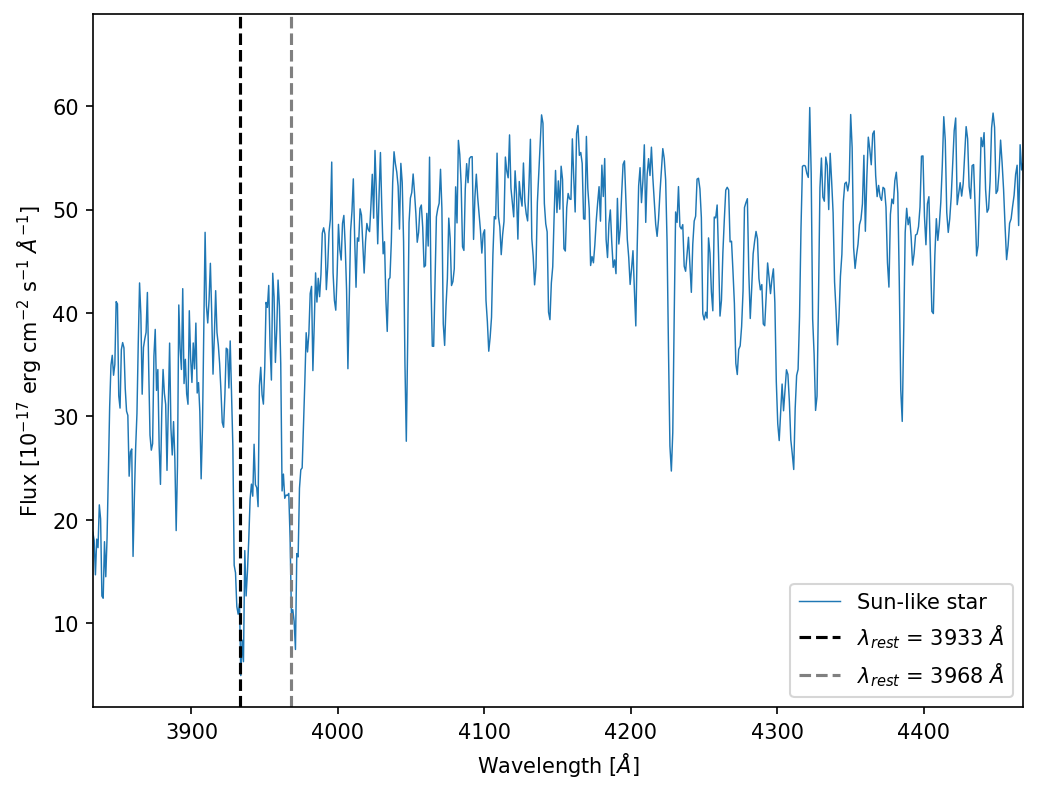

In [30]:
# Plot the sunlike star spectrum
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(sunlike_star[0], sunlike_star[1], lw=0.7, label="Sun-like star")

# Calcium lines (rest wavelengths)
plt.axvline(lambda0[0].value, color='k', ls='--', label=r"$\lambda_{rest}$ = 3933 $\AA$")
plt.axvline(lambda0[1].value, color='grey', ls='--', label=r"$\lambda_{rest}$ = 3968 $\AA$")

# Labels
plt.xlim(lambda0[0].value-100, lambda0[1].value+500)
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Flux [10$^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]")
plt.legend()
plt.show()

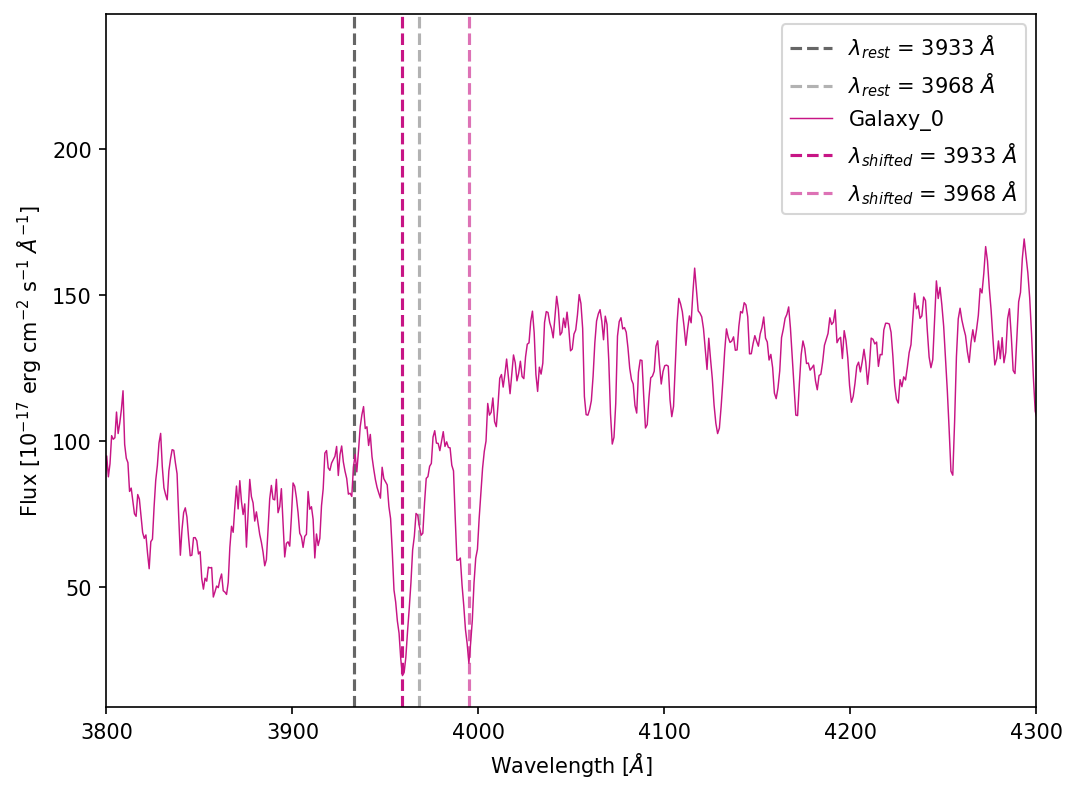

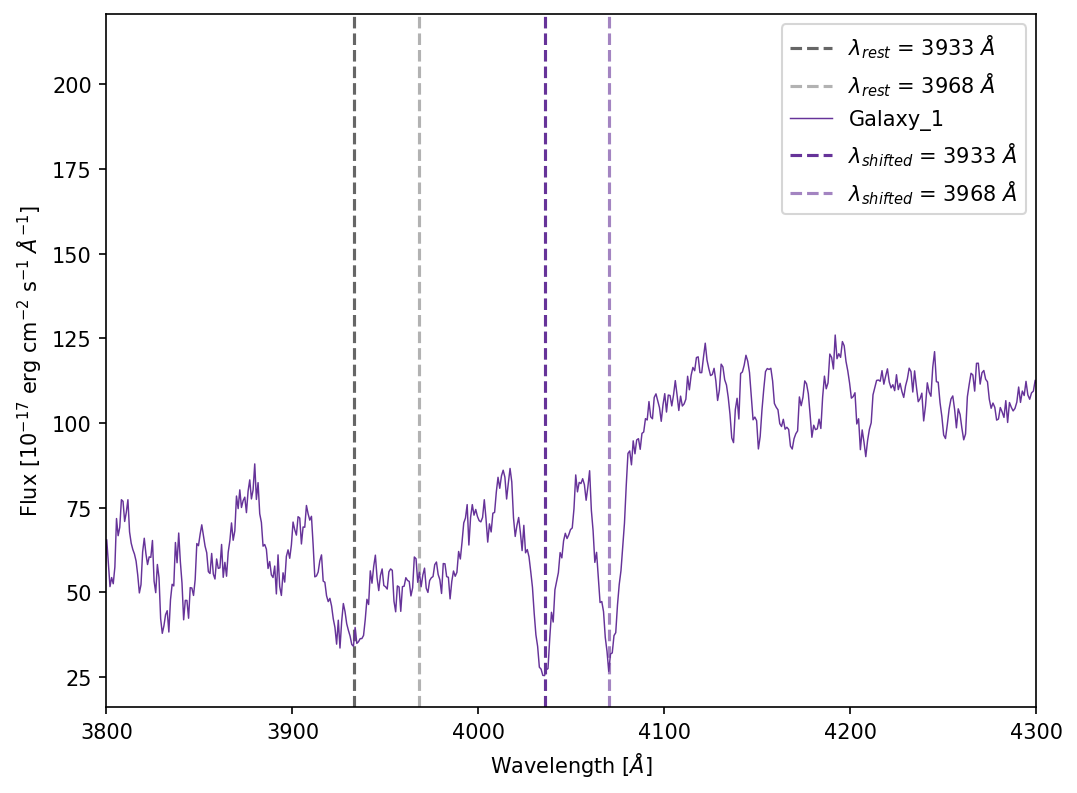

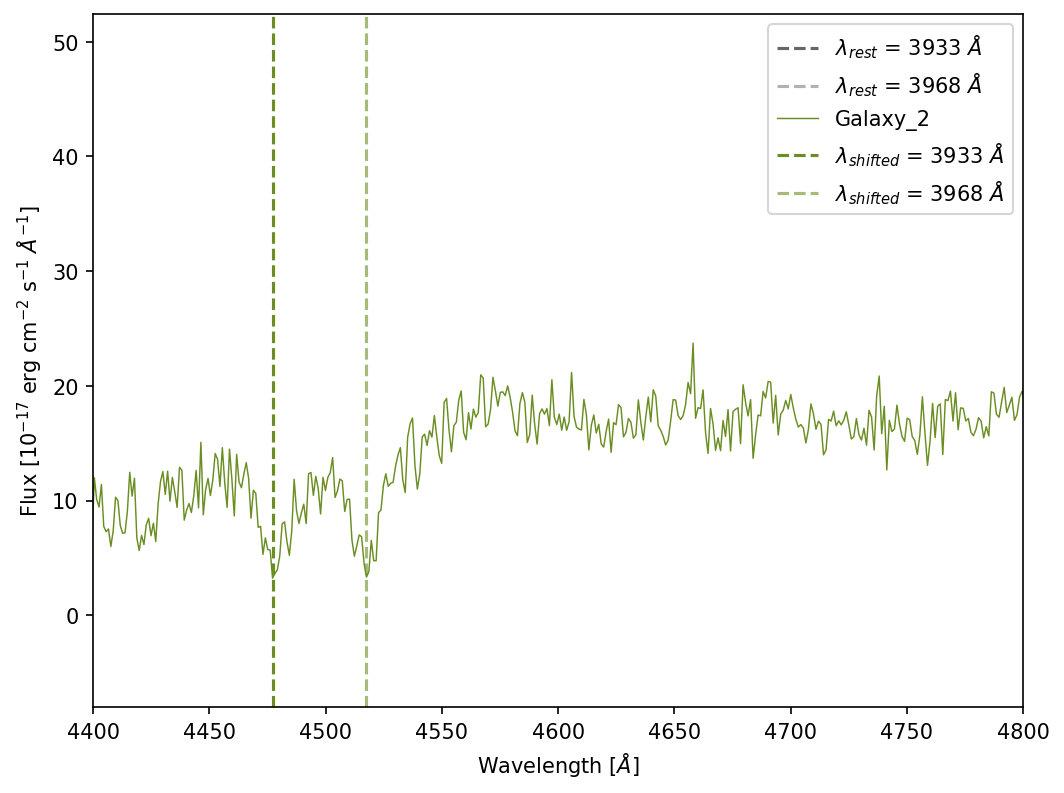

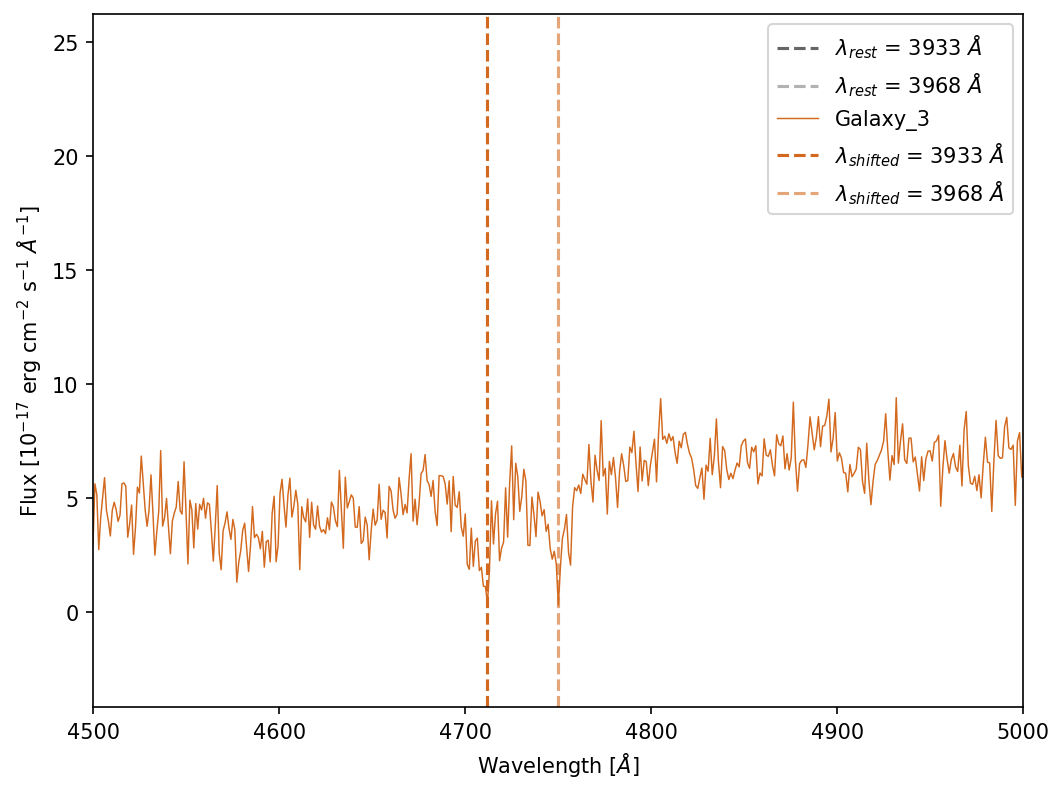

In [31]:
# Plot the galaxy spectra & find the shifted calcium lines
colors = ['mediumvioletred', 'rebeccapurple', 'olivedrab', 'chocolate']
cal_lines1 = []  # shifted wavelengths of 1st Ca line, Å
cal_lines2 = []  # shifted wavelengths of 2nd Ca line, Å

for i, spectrum in enumerate(galaxy_files.values()):
    plt.figure(figsize=(8, 6), dpi=150)

    # Range of x-axis to plot
    # wavelength range
    l_min = 3800 if i<2 else (4400 if i==2 else 4500)
    l_max = 4300 if i<2 else (4800 if i==2 else 5000)
    # get indices
    xmin = np.argmin(np.abs(spectrum[0] - l_min))
    xmax = np.argmin(np.abs(spectrum[0] - l_max))

    # Calcium lines (rest wavelengths)
    plt.axvline(lambda0[0].value, color='k', ls='--', alpha=0.6, label=r"$\lambda_{rest}$ = 3933 $\AA$")
    plt.axvline(lambda0[1].value, color='grey', ls='--', alpha=0.6, label=r"$\lambda_{rest}$ = 3968 $\AA$")
    # Galaxy spectrum
    plt.plot(spectrum[0], spectrum[1], lw=0.7, c=colors[i], label=f"Galaxy_{i}")

    # Find shifted calcium lines
    # first line: search for min in the plotted range
    line1 = np.argmin(spectrum[1][xmin:xmax]) + xmin
    if i==3:  # 2nd line is lower for galaxy3 so we need to adjust the range
        start = line1-int(l_diff.value)-10
        line1 = np.argmin(spectrum[1][start:line1-10]) + start
    cal_lines1.append(spectrum[0][line1])
    # 2nd line: search for min in a smaller range after the first line
    start = line1+10
    stop = line1+int(l_diff.value)+10
    line2 = np.argmin(spectrum[1][start:stop]) + start
    cal_lines2.append(spectrum[0][line2])
    # plot the shifted lines
    plt.axvline(spectrum[0][line1], c=colors[i], ls='--', label=r"$\lambda_{shifted}$ = 3933 $\AA$")
    plt.axvline(spectrum[0][line2], c=colors[i], ls='--', alpha=0.6, label=r"$\lambda_{shifted}$ = 3968 $\AA$")

    # Labels
    plt.xlim(l_min, l_max)
    plt.xlabel(r"Wavelength [$\AA$]")
    plt.ylabel(r"Flux [10$^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]")
    plt.legend()
    plt.show()

In [32]:
# Print info about the calcium doublet
print(f"Rest wavelengths of calcium doublet: {lambda0[0]:.0f}, {lambda0[1]:.0f}")

for i, (l1,l2) in enumerate(zip(cal_lines1, cal_lines2)):
    print(f"Shifted calcium lines, galaxy_{i}: {l1:.2f} Å, {l2:.2f} Å")

Rest wavelengths of calcium doublet: 3933 Angstrom, 3968 Angstrom
Shifted calcium lines, galaxy_0: 3959.13 Å, 3994.85 Å
Shifted calcium lines, galaxy_1: 4035.53 Å, 4070.05 Å
Shifted calcium lines, galaxy_2: 4477.13 Å, 4517.52 Å
Shifted calcium lines, galaxy_3: 4711.94 Å, 4750.07 Å


In [33]:
# Calculate redshift from shifted calcium lines
def redshift(l_obs, l_rest):
    # z = lambda_obs / lambda_rest - 1
    return l_obs / l_rest - 1

z1 = redshift(cal_lines1, lambda0[0].value) # from first Ca line
z2 = redshift(cal_lines2, lambda0[1].value) # from second Ca line
z_avg = (z1 + z2) / 2  # average the redshift for each galaxy

for i,z in enumerate(z_avg):
    print(f"Redshift for galaxy_{i}: {z:.4f}")

Redshift for galaxy_0: 0.0067
Redshift for galaxy_1: 0.0259
Redshift for galaxy_2: 0.1384
Redshift for galaxy_3: 0.1976


iii)

In [45]:
# Functions
def velocity(z):
    # v = c * z
    return const.c * z

def hubble_law(d, v):
    # H0 = v / d
    return v / d

# Calculate velocity from redshift
v = velocity(z_avg)

# Calculate Hubble constant for each galaxy
H0 = hubble_law(distances, v)
for i in range(4):  # print velocity and H0 info
    print(f"Galaxy_{i}:")
    print(f"    v = {v[i].to(u.km/u.s):.2f}")
    print(f"    H0 = {H0[i].to(u.km /u.Mpc /u.s):.2f}")

# Average Hubble constant
H0_avg = np.mean(H0)
print(f"Average H0: {H0_avg.to(u.km /u.Mpc /u.s):.2f}")
print(f"Expected H0: {cosmo.Planck18.H0:.2f}")

# Age of universe
t_universe = 1 / H0_avg
print(f"Age of universe: {t_universe.to(u.Gyr):.2f}")

Galaxy_0:
    v = 2010.10 km / s
    H0 = 36.58 km / (Mpc s)
Galaxy_1:
    v = 7762.68 km / s
    H0 = 51.29 km / (Mpc s)
Galaxy_2:
    v = 41497.07 km / s
    H0 = 131.23 km / (Mpc s)
Galaxy_3:
    v = 59231.09 km / s
    H0 = 31.08 km / (Mpc s)
Average H0: 62.54 km / (Mpc s)
Expected H0: 67.66 km / (Mpc s)
Age of universe: 15.63 Gyr


### Part B

In [46]:
# Load data
sdss_data = pd.read_csv(abs_path + 'data/sdss_ellipticals_140kms_rmagz.csv')

sdss_r = sdss_data['r'].values  # apparent R-band magnitude
sdss_z = sdss_data['z'].values  # redshift
sdss_z_err = sdss_data['zErr'].values  # redshift error

# Given info
v_disp = 140 * u.km / u.s  # velocity dispersion
M_R = -20.5  # absolute R-band magnitude

In [47]:
# Calculate recession velocity and distance for each galaxy
def distance2(M, r):
    """
    r = apparent r-band magnitude
    M = absolute R-band magnitude
    return distance in Mpc
    """
    return 10**((r - M - 25)/5)

sdss_rec_vel = velocity(sdss_z).to(u.km /u.s)  # recession velocity, km/s, fxn defined in part A: v = c*z
sdss_dist = distance2(M_R, sdss_r) * u.Mpc  # distance in Mpc

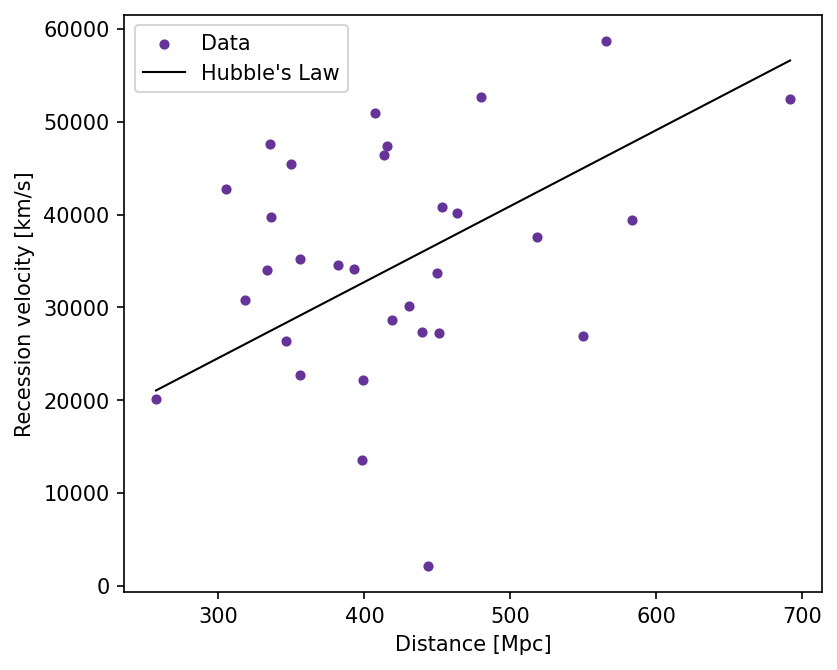

In [37]:
plt.figure(figsize=(6, 5), dpi=150)

# Plot the data
plt.scatter(sdss_dist, sdss_rec_vel, c='rebeccapurple', s=15, label='Data')

# Fit
def hubble_law2(d, H0):
    return H0 * d
popt, pcov = o.curve_fit(hubble_law2, sdss_dist, sdss_rec_vel, p0=70)
H0_fit = popt[0] * u.km /u.Mpc /u.s
H0_fit_err = np.sqrt(np.diag(pcov))[0] * u.km /u.Mpc /u.s

# Plot the fit
d_fit = np.linspace(np.min(sdss_dist), np.max(sdss_dist), 1000)
v_fit = hubble_law2(d_fit, H0_fit)
plt.plot(d_fit, v_fit, c='k', lw=1, label=f"Hubble's Law")

# Labels
plt.xlabel("Distance [Mpc]")
plt.ylabel("Recession velocity [km/s]")
plt.legend()
plt.show()

In [38]:
print(f"Fit H0: {H0_fit:.2f} ± {H0_fit_err:.2f}")

# Age of universe
t_universe_fit = 1 / H0_fit
print(f"Age of universe from fit: {t_universe_fit.to(u.Gyr):.2f}")

Fit H0: 81.86 km / (Mpc s) ± 5.19 km / (Mpc s)
Age of universe from fit: 11.94 Gyr


## Question 2

### Part A

In [39]:
# Load data
redshifts = np.genfromtxt(abs_path + "data/redshift.txt")
ra = np.genfromtxt(abs_path + "data/right ascension.txt")

In [ ]:
# Calculate values for plot
def distance3(z, H0):
    return (3000*z - 607.8*z**2 - 153.6*z**3 + 138.3*z**4) / H0

def position(D, ra):
    return D*np.cos(ra), D*np.sin(ra)  # Mpc

H0 = 0.71 * u.km /u.Mpc /u.s
D = distance3(redshifts, H0=H0) # Mpc
pos = position(D, ra)

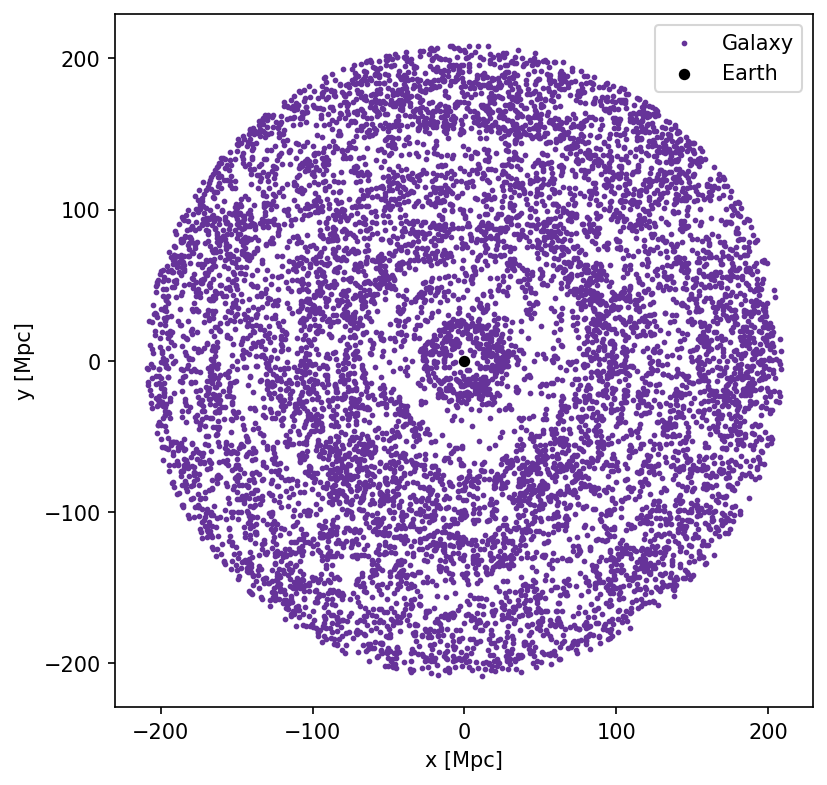

In [41]:
# Plot
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(pos[0], pos[1], c='rebeccapurple', s=3, label='Galaxy')
plt.scatter(0, 0, c='k', s=20, label='Earth')
plt.xlabel("x [Mpc]")
plt.ylabel("y [Mpc]")
plt.legend()
plt.show()

The data appears in a circular pattern around Earth because it represents the observable sky. Galaxies are distributed radially around the observer (Earth), so when their positions are projected onto a 2D map, they form a disk-like shape.

### Part B

In [42]:
def correlation_fxn(N_r, R_r):
    """
    N_r = number of galaxy-galaxy pairs separated by a distance r
    R_r = number of galaxy-galaxy pairs in a random distribution separated by a distance r
    """
    return N_r/R_r - 1

# Load data
N_r = np.genfromtxt(abs_path + "data/data distance.txt")  # km
R_r = np.genfromtxt(abs_path + "data/data random.txt")  # km

# Calculate correlation function
correlation = correlation_fxn(N_r[1:], R_r[1:])  # skip the first value bc R_r = 0...

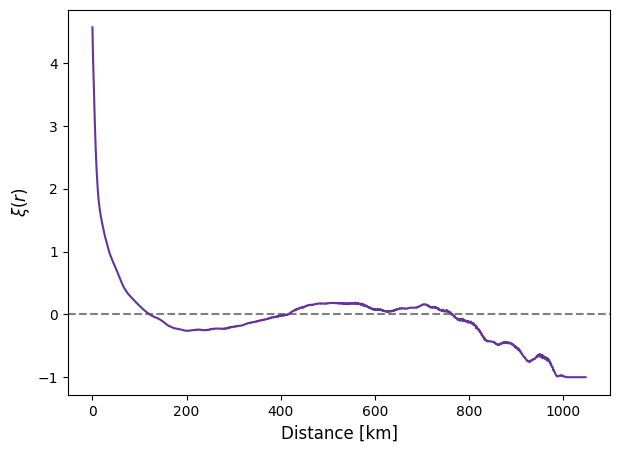

In [43]:
# Plot
plt.figure(figsize=(7, 5), dpi=100)
plt.axhline(0, c='k', ls='--', alpha=0.5)
plt.plot(np.arange(0,len(correlation)), correlation, c='rebeccapurple')
plt.xlabel("Distance [km]", fontsize=12)
plt.ylabel(r"$\xi(r)$", fontsize=12)
plt.show()

### Part C

The plot in part b) is very similar to the one given in the assignment question as they both follow the same trends. The correlation is high for smaller distances and decreases as the distance increases. The negative correlation aroun 200 km indicates underdensities in the distribution of the galaxies, and the increase above 0 around 600 km shows that galaxies are more clustered on these length scales. This agrees with the two-point correlation function for galaxies, as they tend to cluster on small scales (positive correlation) avoid underdensities at intermediate scales (negative correlation), and display weaker clustering on larger scales (positive correlation).